In [5]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader

import argparse
import sys
sys.argv = ['run.py']

import h5py
import copy
import matplotlib.pyplot as plt

In [2]:
from Gan_dense_new import Discriminator, Generator, generate_random_image, generate_random_one_hot, generate_random_seed, Train_D, evaluate_D , Train_G

In [6]:
parser = argparse.ArgumentParser()

parser.add_argument('--batch-size', type=int, default=100, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=100, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')

parser.add_argument('--imgage-size', type=int, default=20,help='input image size')

parser.add_argument('--imgage-patch', type=int, default=4,help='segmentation image patch')

parser.add_argument('--channels', type=int, default=2, help='_')

parser.add_argument('--mlp-dim', type=int, default=500, help='_')


parser.add_argument('--dropout-rate', type=int, default=0.2, help='_')

parser.add_argument('--learning-rate', type=int, default=1e-4, help='_')


args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if args.cuda else "cpu")

## Data preparation

In [8]:
data = []


M_raw = []

#load monte carlo simulation generated raw data
with h5py.File('124_MT_20size_1T_jiangede.hdf5', 'r') as f:

    for i in np.arange(1,51):   
    
        dataset=f[str(i)+'.0K']

        data.append(dataset[:])

        M_raw.append(dataset[:].mean(axis=(0,2,3)).sum())


M_raw=np.array(M_raw)

data=np.array(data)
print(data.shape)

data_T_num, sample_num,_,_,_ = data.shape


data=data.reshape(-1, args.channels*args.imgage_size*args.imgage_size)

print('Train data shape {}'.format(data.shape))
# print('Test data shape {}'.format(data_test.shape))


T = np.linspace(1,50,data_T_num)

#One hot encoding
One_hot_code=np.zeros((data_T_num*sample_num, data_T_num))

for i in range(data_T_num*sample_num):

    One_hot_code[i,i//sample_num]=1
    


#Transform the train data into [0,1],turn into tensor
data_set=(data+1)/2
data_set=torch.tensor(data_set).to(torch.float32)


#Transform the one hot coding to tensor
One_hot_code=torch.tensor(One_hot_code).to(torch.long)

print(data_set.shape)

print(One_hot_code.shape)

# Consolidate data and One hot coding
data_all=[[data_set[i], One_hot_code[i]] for i in range(sample_num*data_T_num)]


print(len(data_all))

(50, 500, 2, 20, 20)
Train data shape (25000, 800)
torch.Size([25000, 800])
torch.Size([25000, 50])
25000


In [10]:
# plt.plot(M_raw,'ro-')
# plt.show()

In [12]:
batchsize=200

shuffled_indices = np.random.permutation(len(data_all))

train_idx = shuffled_indices[:int(0.8*len(data_all))]
val_idx = shuffled_indices[int(0.8*len(data_all)):]

data_train=[data_all[i] for i in train_idx]
data_test=[data_all[i] for i in val_idx]

train_loader = DataLoader(data_train, batch_size = batchsize, shuffle=True)
test_loader = DataLoader(data_test, batch_size = batchsize, shuffle=True )


# train_loader = DataLoader(data_all, batch_size = batchsize, drop_last=False, sampler=SubsetRandomSampler(train_idx))
# test_loader = DataLoader(data_all, batch_size = batchsize, drop_last=False, sampler=SubsetRandomSampler(val_idx) )

## Train Discriminator

In [14]:
%%time
epochs=100
v_dim = args.channels*args.imgage_size*args.imgage_size
# z_dim = 100
h_dim=args.mlp_dim
learning_rate=2e-4
class_num=len(T)

model_D = Discriminator(v_dim=v_dim,  h_dim=h_dim, learning_rate=learning_rate, class_num=class_num, dropout_rate=0.1)
# move model to cuda device
model_D.to(device)

optimizer = torch.optim.Adam(model_D.parameters(), lr=learning_rate)

train_loss_history, test_loss_history, Accuracy_rate = [], [], []
for epoch in range( epochs ):
    # print('Epoch:', epoch)
    Train_D(model_D, optimizer, train_loader, train_loss_history, epoch, class_num)
    evaluate_D(model_D, test_loader, test_loss_history,Accuracy_rate, epoch, class_num)



Epoch: 1, Average train loss: 0.60850
Epoch 1: Average test loss: 1.07044  Accuracy: 6796/10000 (67.96%)

Epoch: 2, Average train loss: 0.54159
Epoch 2: Average test loss: 0.91409  Accuracy: 7373/10000 (73.73%)

Epoch: 3, Average train loss: 0.47265
Epoch 3: Average test loss: 0.80005  Accuracy: 7814/10000 (78.14%)

Epoch: 4, Average train loss: 0.42079
Epoch 4: Average test loss: 0.75922  Accuracy: 7892/10000 (78.92%)

Epoch: 5, Average train loss: 0.39874
Epoch 5: Average test loss: 0.73652  Accuracy: 7985/10000 (79.85%)

Epoch: 6, Average train loss: 0.37960
Epoch 6: Average test loss: 0.73669  Accuracy: 7952/10000 (79.52%)

Epoch: 20, Average train loss: 0.18487
Epoch 20: Average test loss: 0.55564  Accuracy: 8713/10000 (87.13%)

Epoch: 40, Average train loss: 0.08564
Epoch 40: Average test loss: 0.65741  Accuracy: 8822/10000 (88.22%)

Epoch: 60, Average train loss: 0.05848
Epoch 60: Average test loss: 0.75734  Accuracy: 8815/10000 (88.15%)

Epoch: 80, Average train loss: 0.04660
E

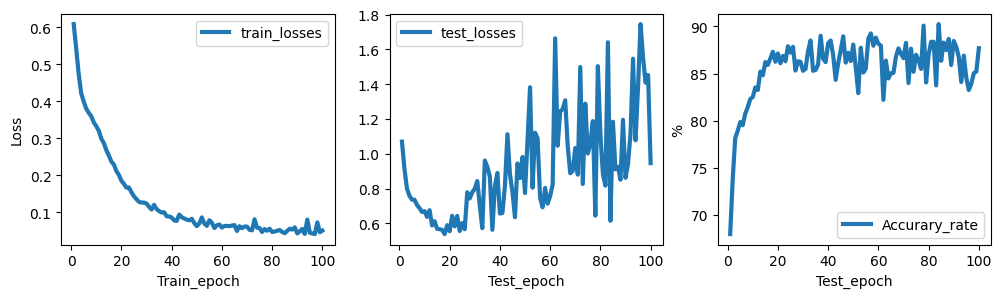

In [15]:
fig=plt.figure(figsize=(12,3))

ax1=plt.subplot(131)
ax1.plot(np.arange(1,len(train_loss_history)+1),train_loss_history, linewidth=3, linestyle='-', label='train_losses')
ax1.set_xlabel('Train_epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2=plt.subplot(132)
ax2.plot(np.arange(1,len(test_loss_history)+1),test_loss_history, linewidth=3, linestyle='-', label='test_losses')
ax2.set_xlabel('Test_epoch')
ax2.legend()

ax3=plt.subplot(133)
ax3.plot(np.arange(1,len(Accuracy_rate)+1),Accuracy_rate, linewidth=3, linestyle='-', label='Accurary_rate')
ax3.set_xlabel('Test_epoch')
ax3.set_ylabel('%')
ax3.legend()

plt.show()

## Train GAN

In [16]:
%%time
epochs=80
v_dim = args.channels*args.imgage_size*args.imgage_size
z_dim = 50
h_dim= args.mlp_dim
learning_rate=1e-4
class_num=len(T)


D_model = Discriminator(v_dim=v_dim,  h_dim=h_dim, learning_rate=learning_rate, class_num=class_num, dropout_rate=0.1)
D_model.to(device)
G_model = Generator(v_dim=v_dim,  h_dim=h_dim, z_dim=z_dim, learning_rate=learning_rate, class_num=class_num, dropout_rate=0.1)
G_model.to(device)#+200

optimizer_d = torch.optim.Adam(D_model.parameters(), lr=learning_rate)
optimizer_g = torch.optim.Adam(G_model.parameters(), lr=learning_rate)


G_loss_history, D_loss_history = [], []
for epoch in range( epochs ):
    # print('Epoch:', epoch)
    Train_G(z_dim, G_model, D_model, optimizer_d, optimizer_g,  train_loader, D_loss_history, G_loss_history, epoch, class_num)


Epoch: 1, D_loss: 0.5095441936701536, G_loss: 1.2906087194383145
Epoch: 2, D_loss: 0.5598955388367176, G_loss: 1.1648714208602906
Epoch: 3, D_loss: 0.5370270961523056, G_loss: 1.1679722142219544
Epoch: 4, D_loss: 0.5581880408525467, G_loss: 1.1047909581661224
Epoch: 5, D_loss: 0.5100404007732868, G_loss: 1.216414225101471
Epoch: 6, D_loss: 0.49175584957003593, G_loss: 1.2396082127094268
Epoch: 10, D_loss: 0.5168179939687252, G_loss: 1.232435611486435
Epoch: 20, D_loss: 0.46409554705023764, G_loss: 1.7346602725982665
Epoch: 30, D_loss: 0.47723933711647987, G_loss: 1.795916998386383
Epoch: 40, D_loss: 0.46728443667292596, G_loss: 2.022952699661255
Epoch: 50, D_loss: 0.44716323405504227, G_loss: 2.307549537420273
Epoch: 60, D_loss: 0.5815035915374756, G_loss: 1.1836482447385788
Epoch: 70, D_loss: 0.6773721805214882, G_loss: 0.8229970848560333
Epoch: 80, D_loss: 0.6729104003310203, G_loss: 0.8305016088485718
Wall time: 2min 23s


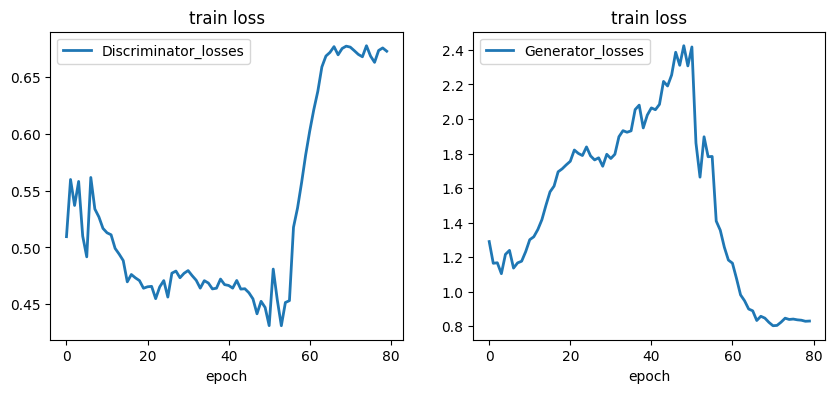

In [17]:
# plot discriminator error

fig = plt.figure(figsize=(10,4))
ax1=plt.subplot(121)
ax1.set_title('train loss')
ax1.plot(np.arange(len(D_loss_history)), D_loss_history, linewidth=2, linestyle='-', label='Discriminator_losses')
ax1.set_xlabel('epoch')
ax1.legend()

ax2=plt.subplot(122)
ax2.set_title('train loss')
ax2.plot(np.arange(len(G_loss_history)), G_loss_history, linewidth=2, linestyle='-', label='Generator_losses')
ax2.set_xlabel('epoch')
ax2.legend()

plt.show()

In [22]:
M_generated=[]
Susceptibility = []

G_model.eval()
torch.no_grad()

sample_num=500
for ii in range(0,len(T)):
    Code=torch.zeros(50)
    Code[ii]=1.0

    cal_M = 0
    cal_M_2=0
    # cal_E = 0
    # cal_E_2 = 0
    for jj in range(sample_num):
        output=G_model.forward(generate_random_seed(1,z_dim).cuda(), Code.reshape(1,50).cuda())
        img = output.detach().cpu().numpy().reshape(2,20,20)
        generated_img=img*2-1

        cal_M += generated_img.mean(axis=(1,2)).sum()
        cal_M_2 += (generated_img.mean(axis=(1,2)).sum())**2


    cal_M = cal_M/sample_num
    cal_M_2 = cal_M_2/sample_num

    # E.append(copy.deepcopy(cal_M))
    # Cv.append(copy.deepcopy((1/(ii+1)**2)*(cal_E_2 - cal_E**2)))

    M_generated.append(cal_M)#.copy()
    Susceptibility.append(((1/(ii+1))*(cal_M_2-cal_M**2)))


M_generated=np.array(M_generated)
Susceptibility=np.array(Susceptibility)

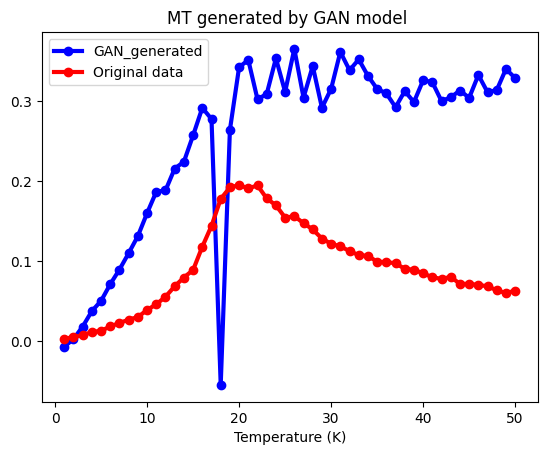

In [23]:
plt.plot(T, M_generated,'bo-',markersize=6,lw=3,label='GAN_generated')
plt.plot(T, M_raw,'ro-',markersize=6,lw=3,label='Original data')
# plt.plot(T, M_raw_test,'yo-',markersize=6,lw=3,label='testl data')

plt.title('MT generated by GAN model ')
plt.xlabel('Temperature (K)')
plt.legend()
plt.show()

Text(0.5, 0, 'Temperature (K)')

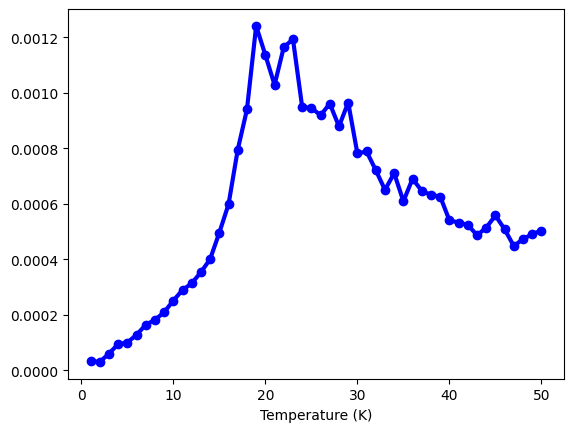

In [24]:
plt.plot(T, Susceptibility,'bo-',markersize=6,lw=3)
plt.xlabel('Temperature (K)')